# Optimization WFA - Linear Regression

## Linear Regression with scikit-learn 

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from util.Save_result_return import save_to_csv

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.style.use("seaborn-v0_8")

In [4]:
from backtesting import Strategy

In [5]:
import warnings
warnings.simplefilter("ignore")

## Getting the Data

In [6]:
XAUUSD = load_data()

In [7]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [8]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


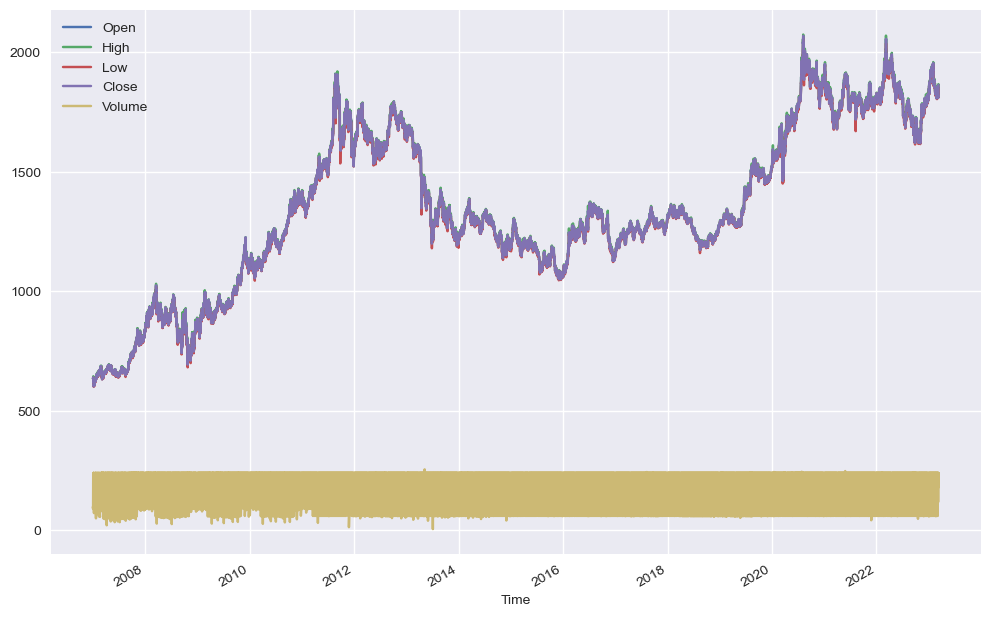

In [9]:
XAUUSD['H4'].plot(figsize = (12, 8))
plt.show()

## ML

### Class and Strategy ML

In [10]:
class Linear_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred[-1] == 1:
            if not self.position :
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)
            
        elif self.data.pred[-1] == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

        

In [11]:
mainFolder = 'Machine_Learning'
strategy = Linear_Regression
strategyName = 'Linear_Regression'
account_size = 10000
folder_ML_Strategy = 'Linear Regression'
subFolder = 'Optimization'

In [12]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from util.Save_result_return import save_to_csv

plt.style.use("seaborn-v0_8")

In [13]:
class ML_Regression():

    def __init__(self, data, strategy, start_train,  end_train,  TF, window_size , account_size):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.end_train = end_train
        self.TF = TF
        self.window_size = window_size
        self.account_size = account_size
        self.data_train = None
        self.results = None
        self.model = None

    def Prepare(self, lags=0):
        data = self.data.loc[self.start_train:self.end_train].copy()
        data["returns"] = np.log(data['Close'] / data['Close'].shift(1))
        data['returns_signal'] = data['returns'].shift(-1)
        # data.dropna(inplace=True)
        cols = []
        for lag in range(lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        # data.dropna(inplace=True)
        data.fillna(0, inplace=True)
        data['pred'] = 0

        for i in range(self.window_size, len(data)):
            rolling_window_data = data.iloc[i - self.window_size :i ]

            lm = LinearRegression(fit_intercept=True)
            lm.fit(rolling_window_data[cols], rolling_window_data['returns_signal'])

            # Predict for the next data point
            pred_value = lm.predict(
                np.array(data[cols].iloc[i] ).reshape(1, -1))
            data.at[data.index[i], 'pred'] = np.sign(pred_value[0])

        self.model = lm
        self.data_train = data.copy()


    def Backtest(self, data):
        # Assuming you have a Backtest class that performs backtesting
        account_size = self.account_size
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin=1/100, commission=0.0002)
        result = backtest.run()
        return result

    

    def Run(self) :
        self.Prepare()
        result_train = self.Backtest(self.data_train)

        return result_train

## TF D1

In [14]:
start_train = '2007'
end_train = '2023'
account_size = 10000
TF = 'D1'

### Window size 1 year

In [15]:
data = XAUUSD['D1']
window_size = 252
WFA = '1y'

In [16]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [17]:
test = ml.Run()

In [18]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   94.983145
Equity Final [$]                  9666.132159
Equity Peak [$]                  10724.469793
Return [%]                          -3.338678
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                   -0.169539
Volatility (Ann.) [%]                2.057054
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -11.735524
Avg. Drawdown [%]                    -0.75895
Max. Drawdown Duration     4218 days 00:00:00
Avg. Drawdown Duration      174 days 00:00:00
# Trades                                 1253
Win Rate [%]                        48.363927
Best Trade [%]                      14.369018
Worst Trade [%]                    -12.519249
Avg. Trade [%]                    

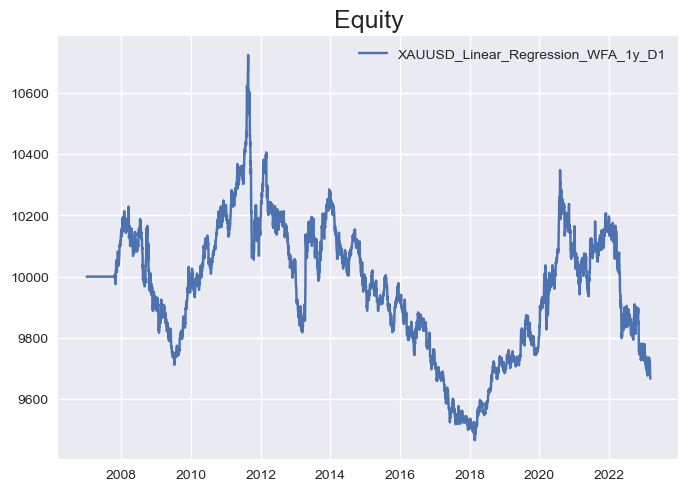

In [19]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [20]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [21]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [22]:
data = XAUUSD['D1']
window_size = 252 * 2
WFA = '2y'

In [23]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [24]:
test = ml.Run()

In [25]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   89.986119
Equity Final [$]                 10134.498649
Equity Peak [$]                   11075.27049
Return [%]                           1.344986
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                    0.066784
Volatility (Ann.) [%]                1.923711
Sharpe Ratio                         0.034716
Sortino Ratio                        0.047823
Calmar Ratio                         0.007732
Max. Drawdown [%]                   -8.637458
Avg. Drawdown [%]                   -0.664304
Max. Drawdown Duration     3262 days 00:00:00
Avg. Drawdown Duration      123 days 00:00:00
# Trades                                  871
Win Rate [%]                        48.450057
Best Trade [%]                      50.321775
Worst Trade [%]                    -18.764488
Avg. Trade [%]                    

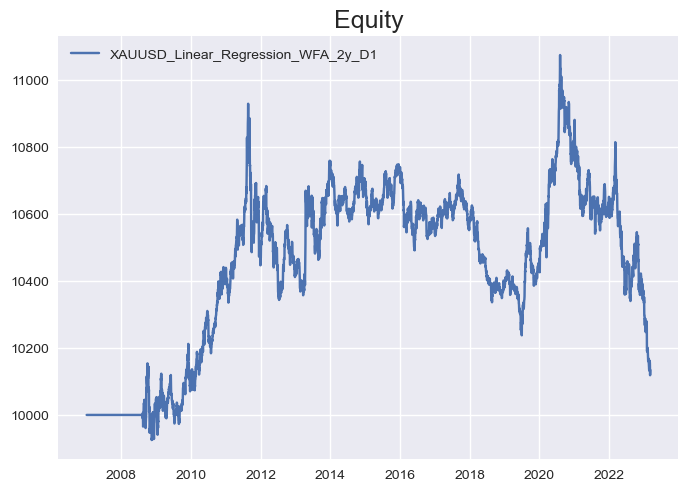

In [26]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [27]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [28]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [29]:
data = XAUUSD['D1']
window_size = 252 * 3
WFA = '3y'

In [30]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [31]:
test = ml.Run()

In [32]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   84.989094
Equity Final [$]                  9138.260347
Equity Peak [$]                  10637.354895
Return [%]                          -8.617397
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                   -0.449295
Volatility (Ann.) [%]                1.989585
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -15.290059
Avg. Drawdown [%]                   -1.085681
Max. Drawdown Duration     4218 days 00:00:00
Avg. Drawdown Duration      227 days 00:00:00
# Trades                                  631
Win Rate [%]                        50.079239
Best Trade [%]                       18.85746
Worst Trade [%]                    -13.687484
Avg. Trade [%]                    

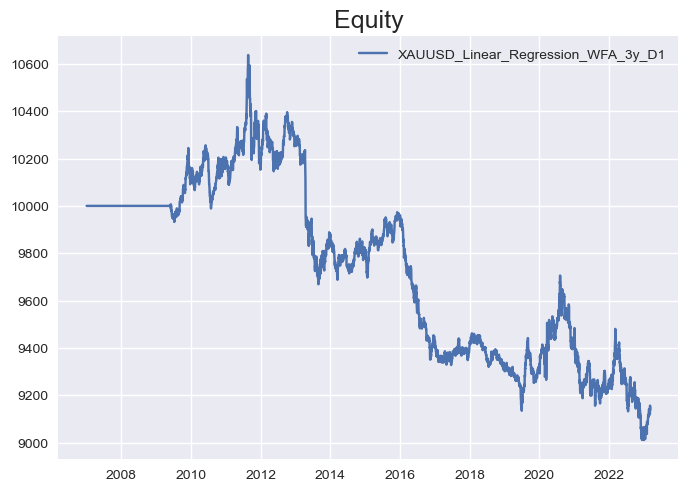

In [33]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [34]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [35]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [36]:
data = XAUUSD['D1']
window_size = 252 * 4
WFA = '4y'

In [37]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [38]:
test = ml.Run()

In [39]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   79.992068
Equity Final [$]                  9765.181313
Equity Peak [$]                   10894.81023
Return [%]                          -2.348187
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                   -0.118669
Volatility (Ann.) [%]                1.895194
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -13.366097
Avg. Drawdown [%]                   -0.539022
Max. Drawdown Duration     4214 days 00:00:00
Avg. Drawdown Duration      112 days 00:00:00
# Trades                                  647
Win Rate [%]                        48.531685
Best Trade [%]                      17.242999
Worst Trade [%]                    -11.111533
Avg. Trade [%]                    

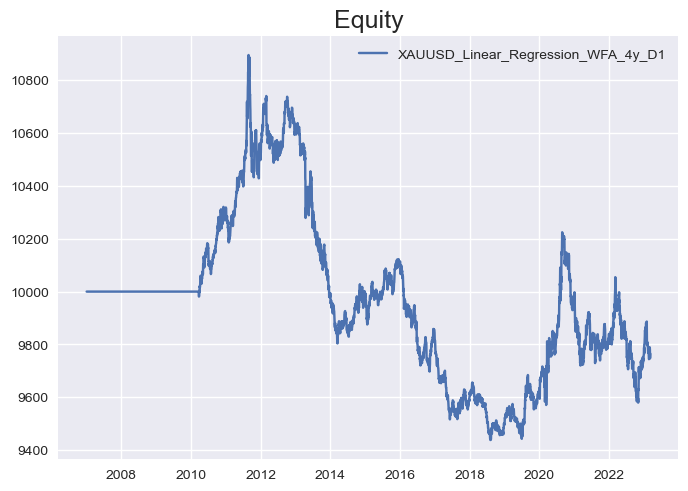

In [40]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [41]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [42]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [43]:
data = XAUUSD['D1']
window_size = 252 * 5
WFA = '5y'

In [44]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [45]:
test = ml.Run()

In [46]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   74.995043
Equity Final [$]                 10271.933897
Equity Peak [$]                  10625.408929
Return [%]                           2.719339
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                    0.134161
Volatility (Ann.) [%]                 1.85016
Sharpe Ratio                         0.072513
Sortino Ratio                        0.098705
Calmar Ratio                         0.013356
Max. Drawdown [%]                  -10.045352
Avg. Drawdown [%]                    -0.82049
Max. Drawdown Duration     4204 days 00:00:00
Avg. Drawdown Duration      232 days 00:00:00
# Trades                                  587
Win Rate [%]                         54.51448
Best Trade [%]                      23.017989
Worst Trade [%]                    -16.927632
Avg. Trade [%]                    

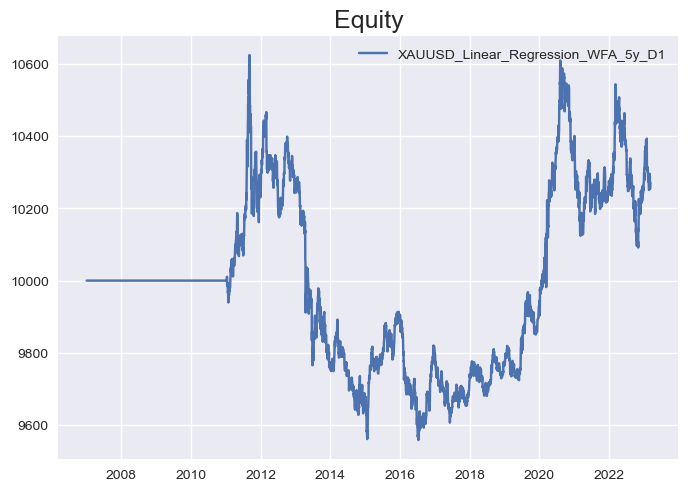

In [47]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [48]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [49]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [50]:
data = XAUUSD['D1']
window_size = 252 * 6
WFA = '6y'

In [51]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [52]:
test = ml.Run()

In [53]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   69.998017
Equity Final [$]                  8933.993941
Equity Peak [$]                  10080.614179
Return [%]                         -10.660061
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                   -0.561689
Volatility (Ann.) [%]                1.886117
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -16.186279
Avg. Drawdown [%]                   -5.546202
Max. Drawdown Duration     4135 days 00:00:00
Avg. Drawdown Duration     1382 days 00:00:00
# Trades                                  587
Win Rate [%]                        53.151618
Best Trade [%]                       8.296012
Worst Trade [%]                    -12.809235
Avg. Trade [%]                    

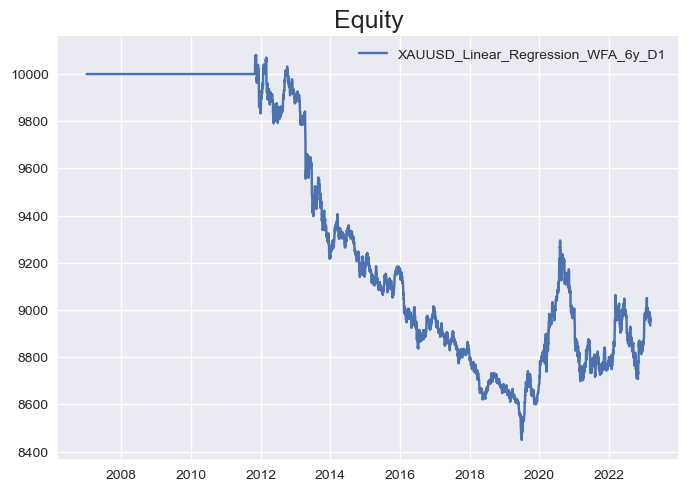

In [54]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [55]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [56]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [57]:
data = XAUUSD['D1']
window_size = 252 * 7
WFA = '7y'

In [58]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [59]:
test = ml.Run()

In [60]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   65.000991
Equity Final [$]                  9097.480183
Equity Peak [$]                   10123.56531
Return [%]                          -9.025198
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                   -0.471541
Volatility (Ann.) [%]                1.760087
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -12.649589
Avg. Drawdown [%]                   -1.662186
Max. Drawdown Duration     3809 days 00:00:00
Avg. Drawdown Duration      480 days 00:00:00
# Trades                                  577
Win Rate [%]                        52.166378
Best Trade [%]                        9.95594
Worst Trade [%]                    -11.233479
Avg. Trade [%]                    

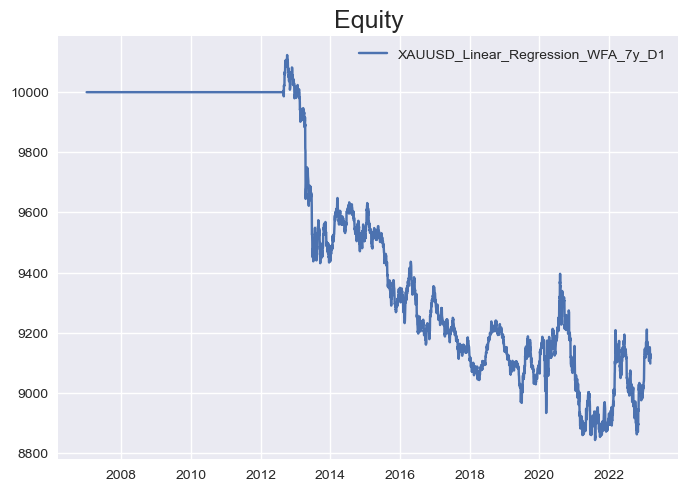

In [61]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [62]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [63]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [64]:
data = XAUUSD['D1']
window_size = 252 * 8
WFA = '8y'

In [65]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [66]:
test = ml.Run()

In [67]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   60.003966
Equity Final [$]                  9419.007512
Equity Peak [$]                  10027.606853
Return [%]                          -5.809925
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                   -0.298652
Volatility (Ann.) [%]                1.615784
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -9.008984
Avg. Drawdown [%]                   -3.625943
Max. Drawdown Duration     3482 days 00:00:00
Avg. Drawdown Duration     1185 days 00:00:00
# Trades                                  497
Win Rate [%]                        51.307847
Best Trade [%]                      11.911252
Worst Trade [%]                    -11.044451
Avg. Trade [%]                    

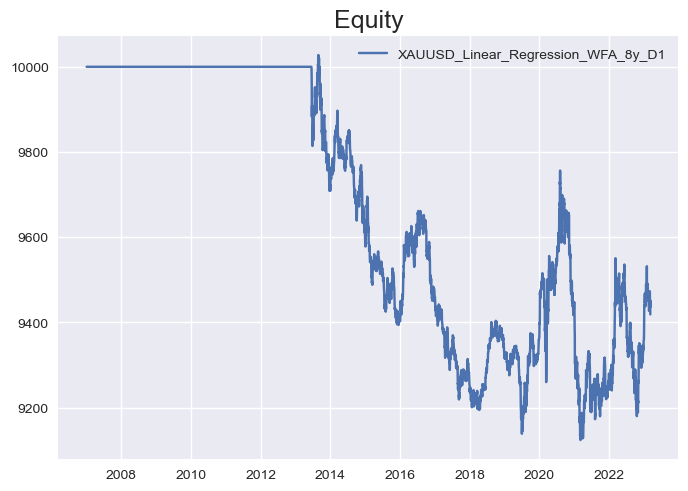

In [68]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [69]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [70]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H4

In [71]:
start_train = '2007'
end_train = '2023'
account_size = 10000
TF = 'H4'

### Window size 1 year

In [72]:
data = XAUUSD['H4']
window_size = 252 * 6
WFA = '1y'

In [73]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [74]:
test = ml.Run()

In [75]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   94.175393
Equity Final [$]                  7613.823307
Equity Peak [$]                   10192.54747
Return [%]                         -23.861767
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                    -1.35305
Volatility (Ann.) [%]                2.232732
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -25.326271
Avg. Drawdown [%]                   -0.974909
Max. Drawdown Duration     5471 days 16:00:00
Avg. Drawdown Duration      191 days 22:00:00
# Trades                                 5963
Win Rate [%]                        46.469898
Best Trade [%]                      21.579252
Worst Trade [%]                    -14.873391
Avg. Trade [%]                    

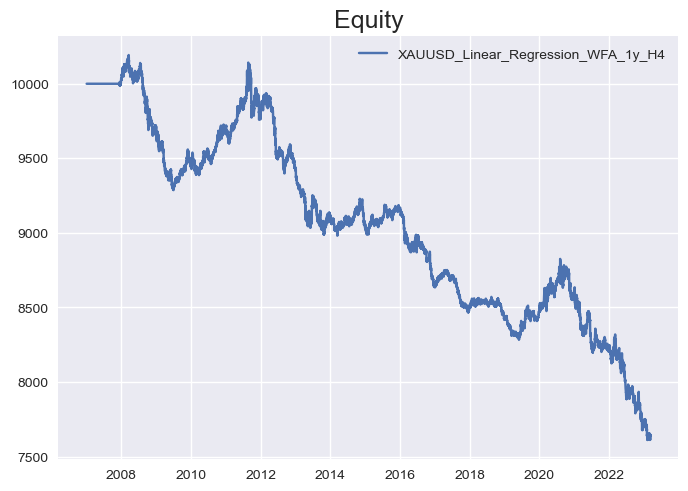

In [76]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [77]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [78]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [79]:
data = XAUUSD['H4']
window_size = 252 * 2 * 6
WFA = '2y'

In [80]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [81]:
test = ml.Run()

In [82]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   88.354635
Equity Final [$]                   8933.17128
Equity Peak [$]                  10643.277155
Return [%]                         -10.668287
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                   -0.562147
Volatility (Ann.) [%]                2.017437
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -16.684136
Avg. Drawdown [%]                    -0.58401
Max. Drawdown Duration     4217 days 20:00:00
Avg. Drawdown Duration       93 days 04:00:00
# Trades                                 5200
Win Rate [%]                        49.096154
Best Trade [%]                      15.684795
Worst Trade [%]                    -10.473901
Avg. Trade [%]                    

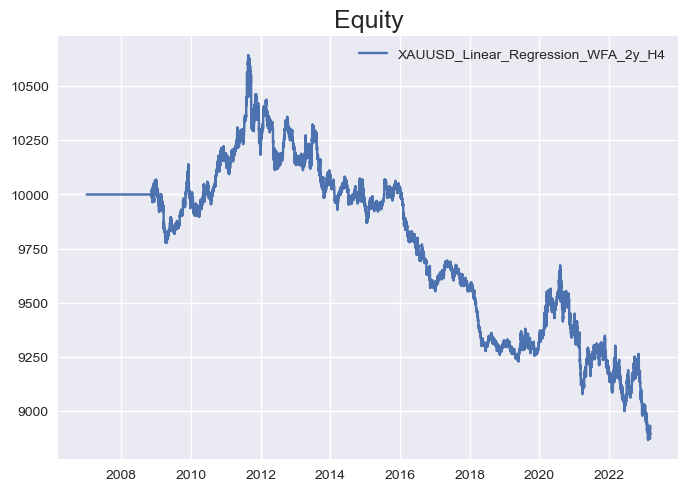

In [83]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [84]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [85]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [86]:
data = XAUUSD['H4']
window_size = 252 * 3 * 6
WFA = '3y'

In [87]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [88]:
test = ml.Run()

In [89]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   82.533877
Equity Final [$]                  8625.295227
Equity Peak [$]                  10759.329741
Return [%]                         -13.747048
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                   -0.736266
Volatility (Ann.) [%]                1.953288
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -21.681036
Avg. Drawdown [%]                   -0.386298
Max. Drawdown Duration     4217 days 16:00:00
Avg. Drawdown Duration       51 days 06:00:00
# Trades                                 5615
Win Rate [%]                        52.235085
Best Trade [%]                      32.702227
Worst Trade [%]                     -8.676069
Avg. Trade [%]                    

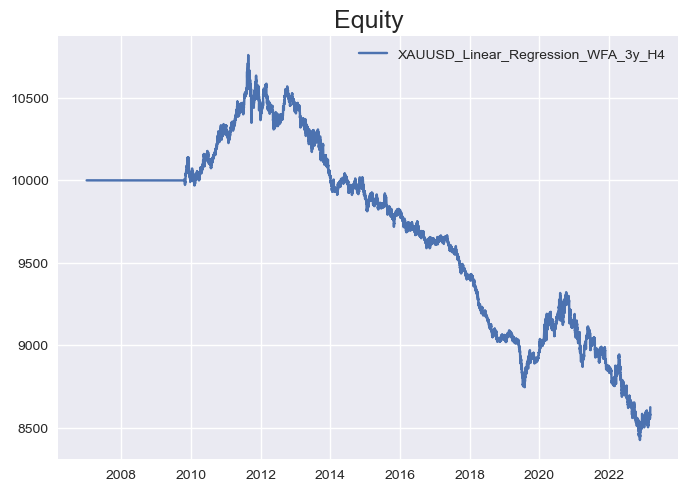

In [90]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [91]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [92]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [93]:
data = XAUUSD['H4']
window_size = 252 * 4 * 6
WFA = '4y'

In [94]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [95]:
test = ml.Run()

In [96]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                    76.71312
Equity Final [$]                  8525.172757
Equity Peak [$]                  10612.793795
Return [%]                         -14.748272
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                   -0.794164
Volatility (Ann.) [%]                1.941428
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -20.829565
Avg. Drawdown [%]                   -0.480103
Max. Drawdown Duration     4217 days 20:00:00
Avg. Drawdown Duration       71 days 23:00:00
# Trades                                 5698
Win Rate [%]                        51.210951
Best Trade [%]                      22.224431
Worst Trade [%]                    -13.992905
Avg. Trade [%]                    

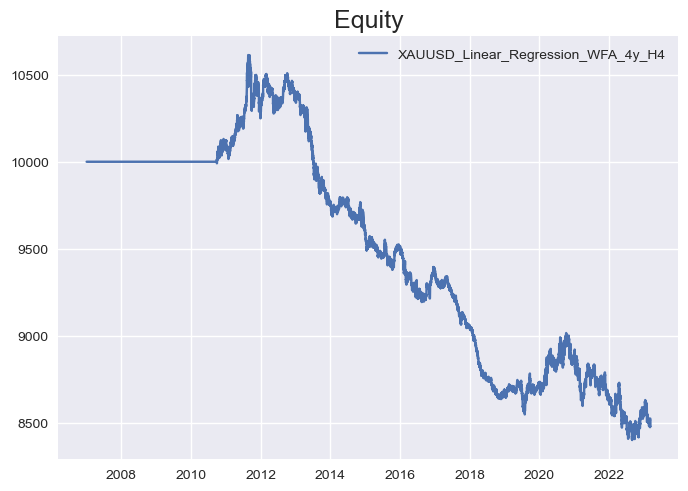

In [97]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [98]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [99]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [100]:
data = XAUUSD['H4']
window_size = 252 * 5 * 6
WFA = '5y'

In [101]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, 500)

In [102]:
test = ml.Run()

In [103]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   18.170619
Equity Final [$]                      0.64781
Equity Peak [$]                     533.11004
Return [%]                         -99.870438
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                  -28.268525
Volatility (Ann.) [%]               56.408673
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.880361
Avg. Drawdown [%]                  -25.557229
Max. Drawdown Duration     4203 days 16:00:00
Avg. Drawdown Duration     1051 days 05:00:00
# Trades                                  291
Win Rate [%]                        39.862543
Best Trade [%]                       6.912373
Worst Trade [%]                    -19.684934
Avg. Trade [%]                    

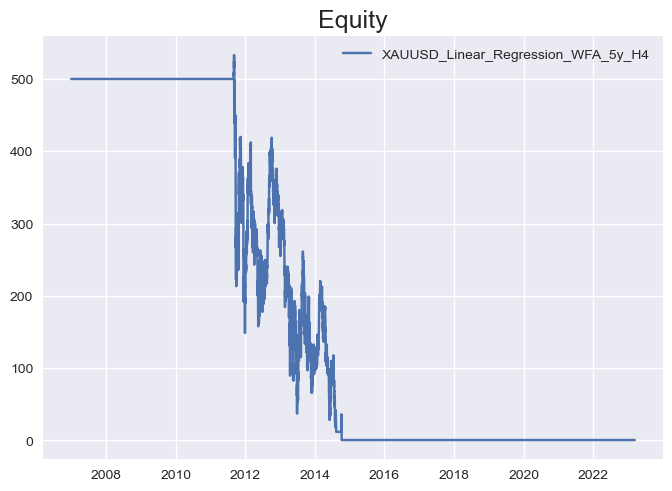

In [104]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [105]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [106]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [107]:
data = XAUUSD['H4']
window_size = 252 * 6 * 6
WFA = '6y'

In [108]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [109]:
test = ml.Run()

In [110]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   65.071605
Equity Final [$]                  8835.597102
Equity Peak [$]                  10178.489977
Return [%]                         -11.644029
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                   -0.616704
Volatility (Ann.) [%]                1.691204
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -14.699106
Avg. Drawdown [%]                    -0.64692
Max. Drawdown Duration     3808 days 16:00:00
Avg. Drawdown Duration      148 days 09:00:00
# Trades                                 4622
Win Rate [%]                        50.735612
Best Trade [%]                      10.549655
Worst Trade [%]                     -7.295814
Avg. Trade [%]                    

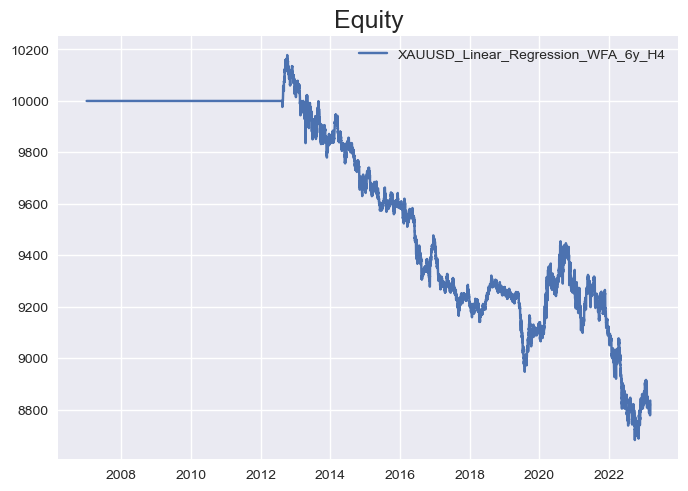

In [111]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [112]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [113]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [114]:
data = XAUUSD['H4']
window_size = 252 * 7 * 6
WFA = '7y'

In [115]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [116]:
test = ml.Run()

In [117]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   59.250847
Equity Final [$]                  8593.150843
Equity Peak [$]                  10092.363239
Return [%]                         -14.068492
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                   -0.754784
Volatility (Ann.) [%]                1.627021
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -15.770287
Avg. Drawdown [%]                    -1.69539
Max. Drawdown Duration     3481 days 12:00:00
Avg. Drawdown Duration      351 days 05:00:00
# Trades                                 3830
Win Rate [%]                        50.652742
Best Trade [%]                       6.398181
Worst Trade [%]                     -5.565864
Avg. Trade [%]                    

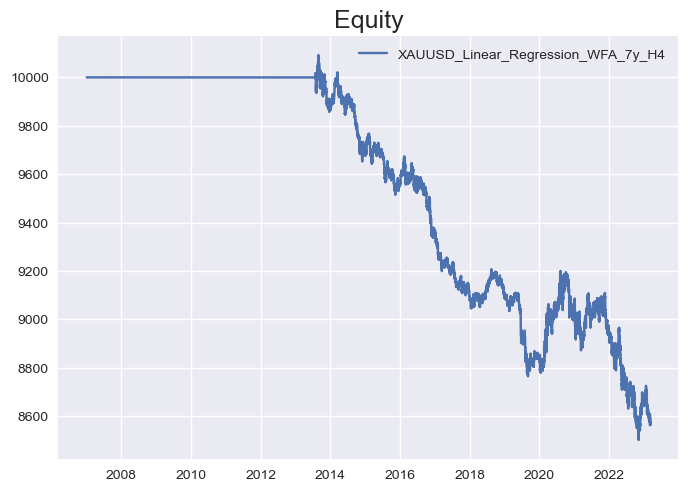

In [118]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [119]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [120]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [121]:
data = XAUUSD['H4']
window_size = 252 * 8 * 6
WFA = '8y'

In [122]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [123]:
test = ml.Run()

In [124]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   53.430089
Equity Final [$]                  8210.474832
Equity Peak [$]                  10025.257657
Return [%]                         -17.895252
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                   -0.980447
Volatility (Ann.) [%]                1.582298
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -18.616652
Avg. Drawdown [%]                   -2.350862
Max. Drawdown Duration     3165 days 08:00:00
Avg. Drawdown Duration      396 days 02:00:00
# Trades                                 3400
Win Rate [%]                        51.382353
Best Trade [%]                       7.894084
Worst Trade [%]                    -11.469259
Avg. Trade [%]                    

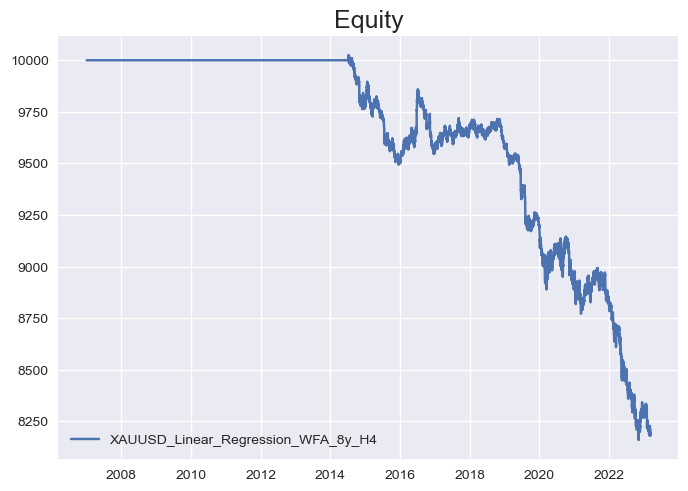

In [125]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [126]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [127]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H1

In [128]:
start_train = '2007'
end_train = '2023'
account_size = 10000
TF = 'H1'

### Window size 1 year

In [129]:
data = XAUUSD['H1']
window_size = 252 * 24
WFA = '1y'

In [130]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [131]:
test = ml.Run()

In [132]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 17:00:00
Exposure Time [%]                   93.824652
Equity Final [$]                  3930.672583
Equity Peak [$]                  10089.558427
Return [%]                         -60.693274
Buy & Hold Return [%]               193.27055
Return (Ann.) [%]                   -4.558907
Volatility (Ann.) [%]                2.912314
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -61.043906
Avg. Drawdown [%]                   -1.639119
Max. Drawdown Duration     5477 days 21:00:00
Avg. Drawdown Duration      142 days 14:00:00
# Trades                                26605
Win Rate [%]                        47.633903
Best Trade [%]                        8.28777
Worst Trade [%]                     -9.104716
Avg. Trade [%]                    

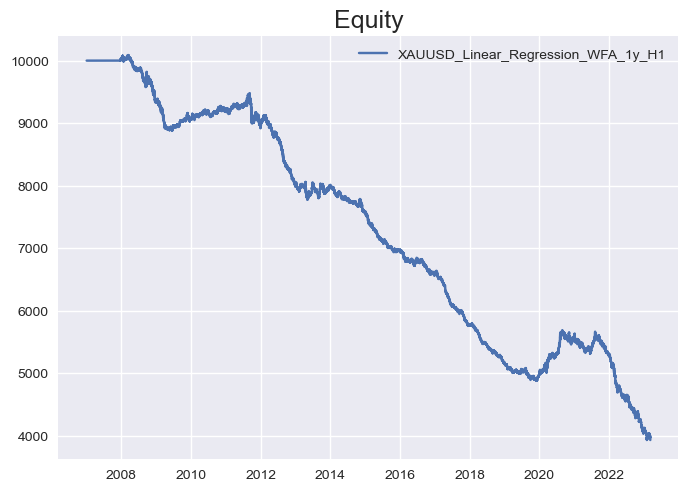

In [133]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [134]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [135]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [136]:
data = XAUUSD['H1']
window_size = 252 * 2 * 24
WFA = '2y'

In [137]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [138]:
test = ml.Run()

In [139]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 17:00:00
Exposure Time [%]                   87.650326
Equity Final [$]                  5321.220616
Equity Peak [$]                  10439.727083
Return [%]                         -46.787794
Buy & Hold Return [%]               193.27055
Return (Ann.) [%]                   -3.103361
Volatility (Ann.) [%]                2.358874
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -49.304313
Avg. Drawdown [%]                   -0.813138
Max. Drawdown Duration     4218 days 14:00:00
Avg. Drawdown Duration       66 days 18:00:00
# Trades                                21191
Win Rate [%]                        45.434383
Best Trade [%]                      10.345115
Worst Trade [%]                     -5.940401
Avg. Trade [%]                    

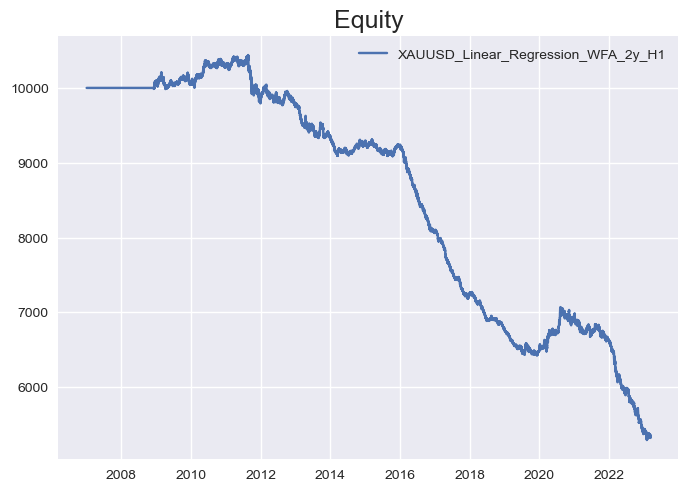

In [140]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [141]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [142]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [143]:
data = XAUUSD['H1']
window_size = 252 * 3 * 24
WFA = '3y'

In [144]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [145]:
test = ml.Run()

In [146]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 17:00:00
Exposure Time [%]                   81.475999
Equity Final [$]                  4548.346213
Equity Peak [$]                  10561.162148
Return [%]                         -54.516538
Buy & Hold Return [%]               193.27055
Return (Ann.) [%]                    -3.86028
Volatility (Ann.) [%]                2.451199
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -57.147436
Avg. Drawdown [%]                   -0.477041
Max. Drawdown Duration     4218 days 14:00:00
Avg. Drawdown Duration       31 days 03:00:00
# Trades                                21337
Win Rate [%]                        42.250551
Best Trade [%]                       8.393908
Worst Trade [%]                     -14.89086
Avg. Trade [%]                    

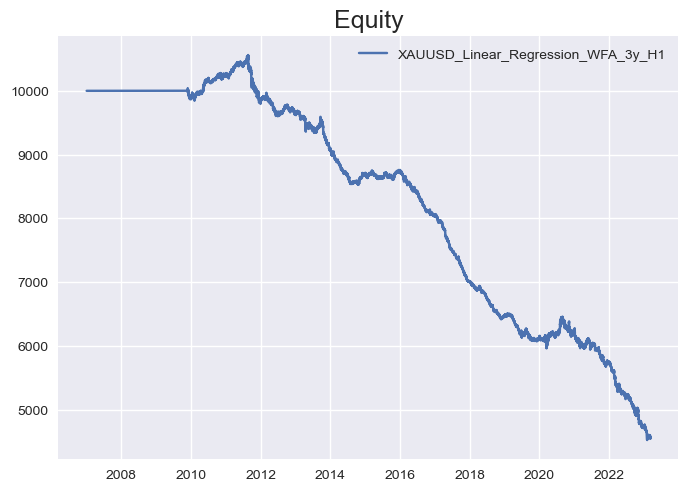

In [147]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [148]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [149]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [150]:
data = XAUUSD['H1']
window_size = 252 * 4 * 24
WFA = '4y'

In [151]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [152]:
test = ml.Run()

In [153]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 17:00:00
Exposure Time [%]                   75.301672
Equity Final [$]                  4711.598361
Equity Peak [$]                  10347.397531
Return [%]                         -52.884016
Buy & Hold Return [%]               193.27055
Return (Ann.) [%]                    -3.69072
Volatility (Ann.) [%]                 2.59325
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -55.017639
Avg. Drawdown [%]                   -0.755429
Max. Drawdown Duration     4216 days 16:00:00
Avg. Drawdown Duration       51 days 04:00:00
# Trades                                19357
Win Rate [%]                        41.230563
Best Trade [%]                      10.161948
Worst Trade [%]                     -7.886024
Avg. Trade [%]                    

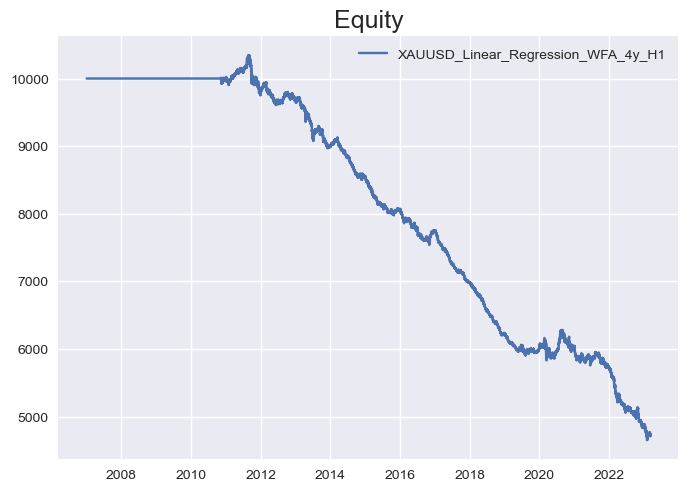

In [154]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [155]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [156]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [157]:
data = XAUUSD['H1']
window_size = 252 * 5 * 24
WFA = '5y'

In [158]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [159]:
test = ml.Run()

In [160]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 17:00:00
Exposure Time [%]                   69.127345
Equity Final [$]                  4540.088391
Equity Peak [$]                  10023.712055
Return [%]                         -54.599116
Buy & Hold Return [%]               193.27055
Return (Ann.) [%]                    -3.86901
Volatility (Ann.) [%]                2.518318
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -55.009574
Avg. Drawdown [%]                   -9.409112
Max. Drawdown Duration     4132 days 21:00:00
Avg. Drawdown Duration      691 days 11:00:00
# Trades                                17469
Win Rate [%]                        41.038411
Best Trade [%]                      22.111632
Worst Trade [%]                    -12.817591
Avg. Trade [%]                    

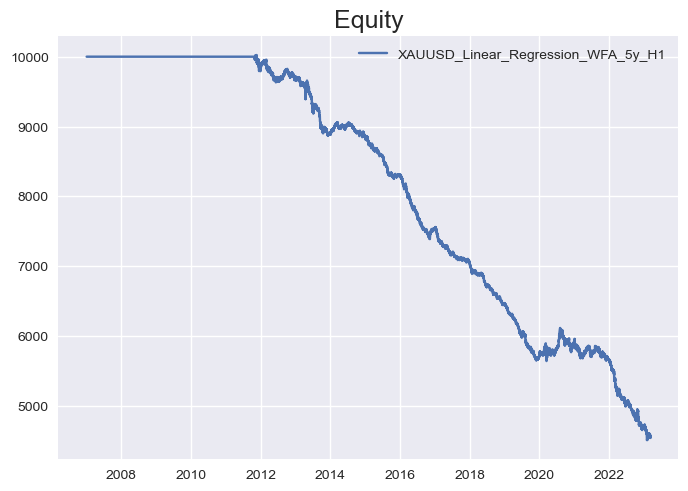

In [161]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [162]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [163]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [164]:
data = XAUUSD['H1']
window_size = 252 * 6 * 24
WFA = '6y'

In [165]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [166]:
test = ml.Run()

In [167]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 17:00:00
Exposure Time [%]                   62.953019
Equity Final [$]                   4694.95882
Equity Peak [$]                  10033.208361
Return [%]                         -53.050412
Buy & Hold Return [%]               193.27055
Return (Ann.) [%]                   -3.707745
Volatility (Ann.) [%]                2.381171
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -53.615672
Avg. Drawdown [%]                   -4.560999
Max. Drawdown Duration     3759 days 02:00:00
Avg. Drawdown Duration      315 days 14:00:00
# Trades                                14777
Win Rate [%]                         40.48183
Best Trade [%]                       4.028618
Worst Trade [%]                     -7.886024
Avg. Trade [%]                    

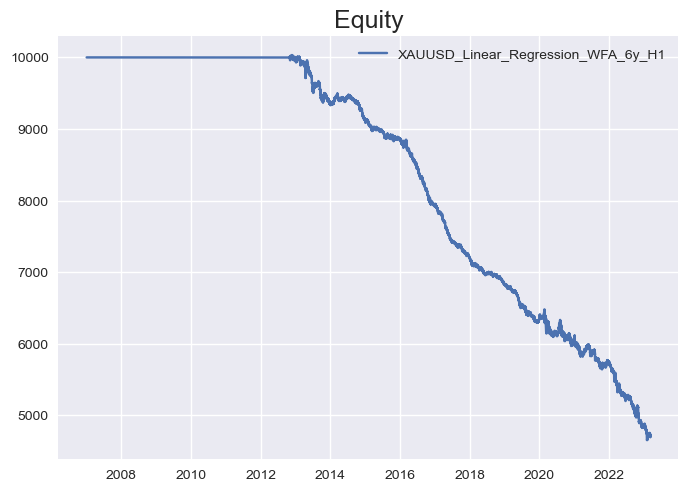

In [168]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [169]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [170]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [171]:
data = XAUUSD['H1']
window_size = 252 * 7 * 24
WFA = '7y'

In [172]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [173]:
test = ml.Run()

In [174]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 17:00:00
Exposure Time [%]                   56.778692
Equity Final [$]                  4674.731219
Equity Peak [$]                  10073.048689
Return [%]                         -53.252688
Buy & Hold Return [%]               193.27055
Return (Ann.) [%]                   -3.728519
Volatility (Ann.) [%]                2.270347
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -54.466216
Avg. Drawdown [%]                   -2.391044
Max. Drawdown Duration     3283 days 05:00:00
Avg. Drawdown Duration      142 days 12:00:00
# Trades                                14877
Win Rate [%]                        39.900518
Best Trade [%]                       7.520429
Worst Trade [%]                     -5.152793
Avg. Trade [%]                    

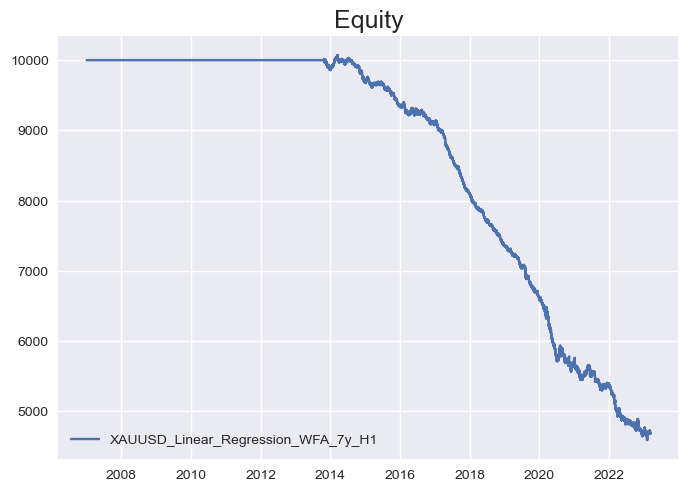

In [175]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [176]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [177]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [178]:
data = XAUUSD['H1']
window_size = 252 * 8 * 24
WFA = '8y'

In [179]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [180]:
test = ml.Run()

In [181]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 17:00:00
Exposure Time [%]                   50.604365
Equity Final [$]                  4537.656404
Equity Peak [$]                  10009.290222
Return [%]                         -54.623436
Buy & Hold Return [%]               193.27055
Return (Ann.) [%]                   -3.871584
Volatility (Ann.) [%]                2.164358
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -55.502651
Avg. Drawdown [%]                  -55.502651
Max. Drawdown Duration     3055 days 03:00:00
Avg. Drawdown Duration     3055 days 03:00:00
# Trades                                13709
Win Rate [%]                         39.12758
Best Trade [%]                       4.413498
Worst Trade [%]                     -7.404404
Avg. Trade [%]                    

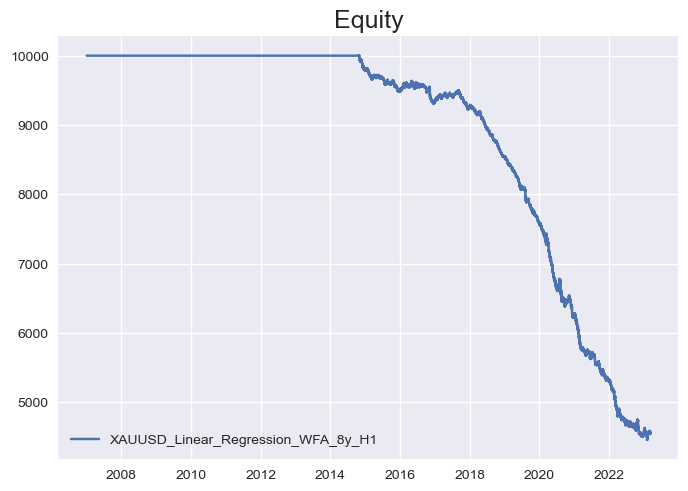

In [182]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [183]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [184]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H30

In [185]:
start_train = '2007'
end_train = '2023'
account_size = 10000
TF = 'M30'

### Window size 1 year

In [186]:
data = XAUUSD['M30']
window_size = 252 * 48
WFA = '1y'

In [187]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [188]:
test = ml.Run()

In [189]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:30:00
Duration                   5912 days 17:30:00
Exposure Time [%]                   78.559904
Equity Final [$]                     9.641186
Equity Peak [$]                  10007.344054
Return [%]                         -99.903588
Buy & Hold Return [%]              193.338852
Return (Ann.) [%]                  -29.320051
Volatility (Ann.) [%]               54.744931
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.920736
Avg. Drawdown [%]                  -33.335533
Max. Drawdown Duration     5559 days 17:00:00
Avg. Drawdown Duration     1853 days 12:30:00
# Trades                                39069
Win Rate [%]                         46.09537
Best Trade [%]                      14.954401
Worst Trade [%]                    -11.583897
Avg. Trade [%]                    

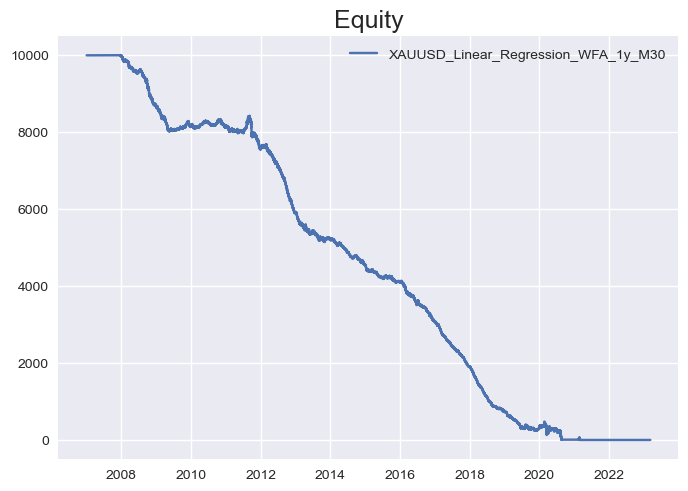

In [190]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [191]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [192]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [193]:
data = XAUUSD['M30']
window_size = 252 * 2 * 48
WFA = '2y'

In [194]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [195]:
test = ml.Run()

In [196]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:30:00
Duration                   5912 days 17:30:00
Exposure Time [%]                   85.653846
Equity Final [$]                    14.744068
Equity Peak [$]                   10184.31008
Return [%]                         -99.852559
Buy & Hold Return [%]              193.338852
Return (Ann.) [%]                  -27.803676
Volatility (Ann.) [%]               17.018584
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.874659
Avg. Drawdown [%]                   -2.078157
Max. Drawdown Duration     4216 days 15:30:00
Avg. Drawdown Duration       96 days 10:37:00
# Trades                                41960
Win Rate [%]                        51.477598
Best Trade [%]                      21.802114
Worst Trade [%]                     -7.786647
Avg. Trade [%]                    

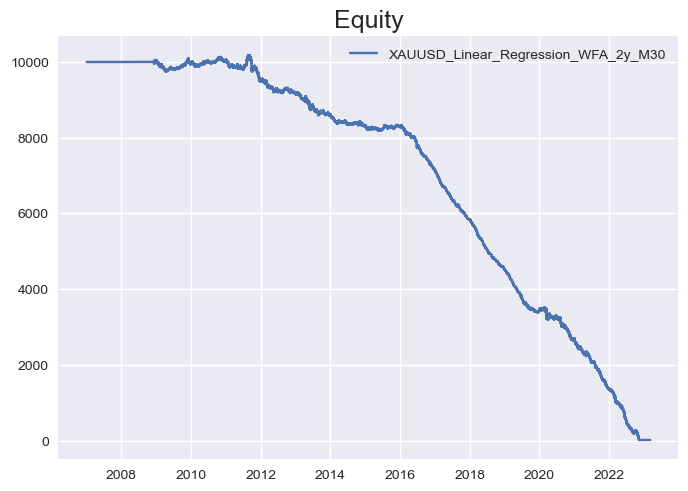

In [197]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [198]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [199]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [200]:
data = XAUUSD['M30']
window_size = 252 * 3 * 48
WFA = '3y'

In [201]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [202]:
test = ml.Run()

In [203]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:30:00
Duration                   5912 days 17:30:00
Exposure Time [%]                   79.185298
Equity Final [$]                    13.394349
Equity Peak [$]                  10616.558481
Return [%]                         -99.866057
Buy & Hold Return [%]              193.338852
Return (Ann.) [%]                  -28.149212
Volatility (Ann.) [%]               22.073385
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.888341
Avg. Drawdown [%]                   -0.694312
Max. Drawdown Duration     4203 days 03:00:00
Avg. Drawdown Duration       28 days 16:55:00
# Trades                                40502
Win Rate [%]                        51.232038
Best Trade [%]                       8.988946
Worst Trade [%]                     -8.241291
Avg. Trade [%]                    

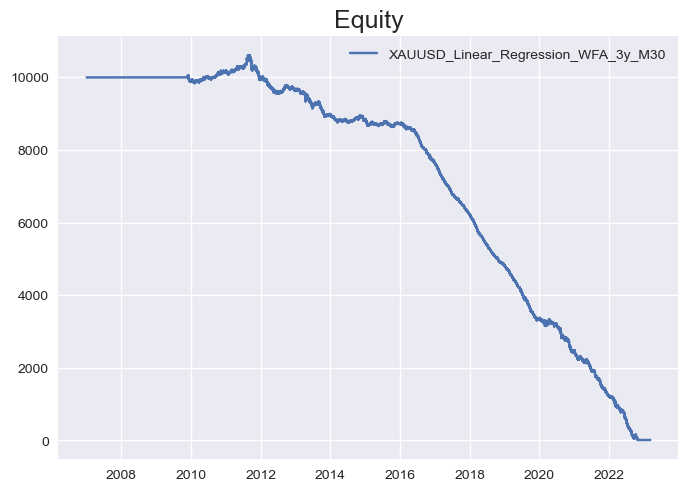

In [204]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [205]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [206]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [207]:
data = XAUUSD['M30']
window_size = 252 * 4 * 48
WFA = '4y'

In [208]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [209]:
test = ml.Run()

In [210]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:30:00
Duration                   5912 days 17:30:00
Exposure Time [%]                     75.2173
Equity Final [$]                   115.440676
Equity Peak [$]                  10287.993983
Return [%]                         -98.845593
Buy & Hold Return [%]              193.338852
Return (Ann.) [%]                  -19.984232
Volatility (Ann.) [%]               13.993761
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.045501
Avg. Drawdown [%]                   -2.893864
Max. Drawdown Duration     4203 days 11:30:00
Avg. Drawdown Duration      121 days 15:59:00
# Trades                                40242
Win Rate [%]                        52.611699
Best Trade [%]                       4.677259
Worst Trade [%]                    -13.635623
Avg. Trade [%]                    

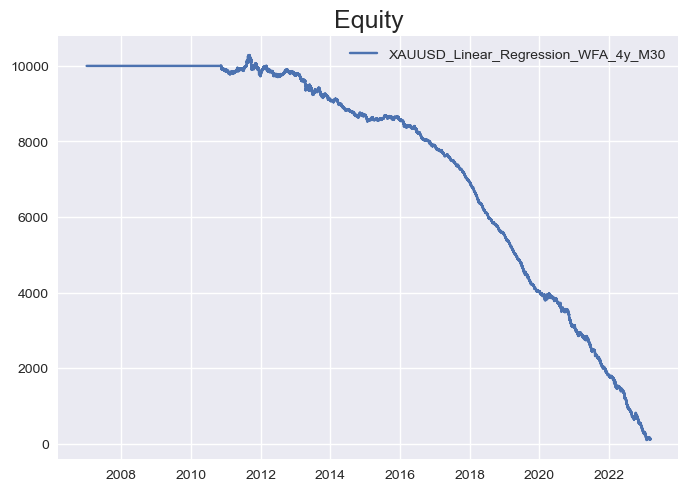

In [211]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [212]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [213]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [214]:
data = XAUUSD['M30']
window_size = 252 * 5 * 48
WFA = '5y'

In [215]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [216]:
test = ml.Run()

In [217]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:30:00
Duration                   5912 days 17:30:00
Exposure Time [%]                   69.021753
Equity Final [$]                   442.118168
Equity Peak [$]                       10000.0
Return [%]                         -95.578818
Buy & Hold Return [%]              193.338852
Return (Ann.) [%]                  -14.430852
Volatility (Ann.) [%]                6.343037
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -95.650472
Avg. Drawdown [%]                  -95.650472
Max. Drawdown Duration     4148 days 18:00:00
Avg. Drawdown Duration     4148 days 18:00:00
# Trades                                38364
Win Rate [%]                        53.226984
Best Trade [%]                       8.782136
Worst Trade [%]                    -19.596496
Avg. Trade [%]                    

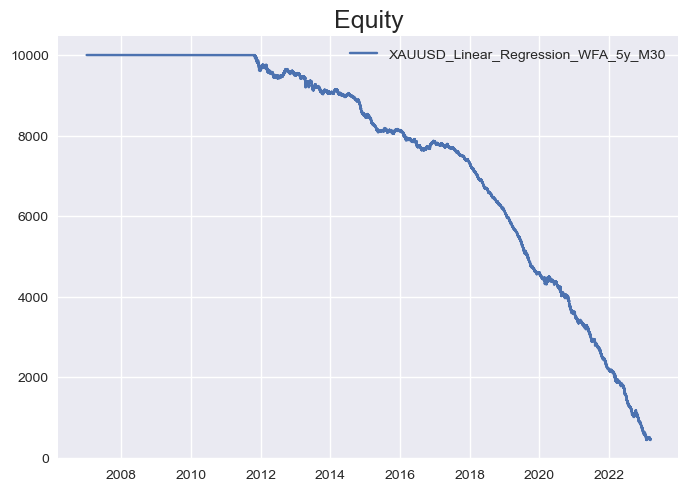

In [218]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [219]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [220]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [221]:
data = XAUUSD['M30']
window_size = 252 * 6 * 48
WFA = '6y'

In [222]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [223]:
test = ml.Run()

In [224]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:30:00
Duration                   5912 days 17:30:00
Exposure Time [%]                   62.826206
Equity Final [$]                   338.042485
Equity Peak [$]                  10033.389108
Return [%]                         -96.619575
Buy & Hold Return [%]              193.338852
Return (Ann.) [%]                  -15.570869
Volatility (Ann.) [%]                7.345562
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -96.792258
Avg. Drawdown [%]                   -8.170654
Max. Drawdown Duration     3755 days 16:30:00
Avg. Drawdown Duration      315 days 03:53:00
# Trades                                37722
Win Rate [%]                        53.886326
Best Trade [%]                        4.13762
Worst Trade [%]                    -10.350193
Avg. Trade [%]                    

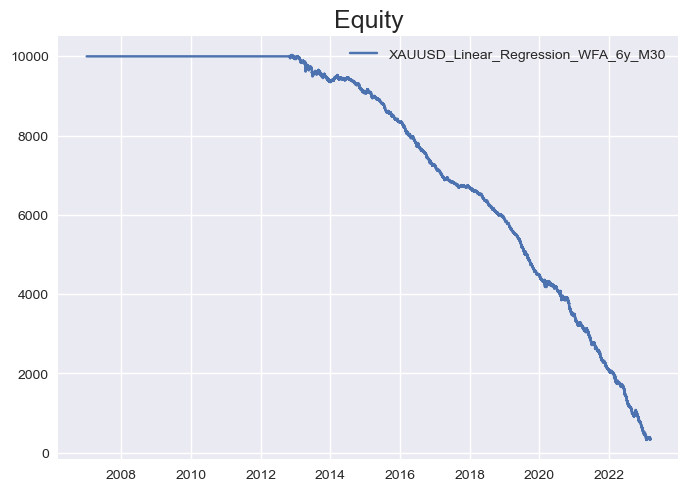

In [225]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [226]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [227]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [228]:
data = XAUUSD['M30']
window_size = 252 * 7 * 48 
WFA = '7y'

In [229]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [230]:
test = ml.Run()

In [231]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:30:00
Duration                   5912 days 17:30:00
Exposure Time [%]                   56.630659
Equity Final [$]                   588.285438
Equity Peak [$]                  10051.578807
Return [%]                         -94.117146
Buy & Hold Return [%]              193.338852
Return (Ann.) [%]                  -13.200744
Volatility (Ann.) [%]                5.428829
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -94.316256
Avg. Drawdown [%]                   -6.413164
Max. Drawdown Duration     3283 days 05:00:00
Avg. Drawdown Duration      227 days 10:18:00
# Trades                                37380
Win Rate [%]                        53.456394
Best Trade [%]                       4.994051
Worst Trade [%]                     -7.317696
Avg. Trade [%]                    

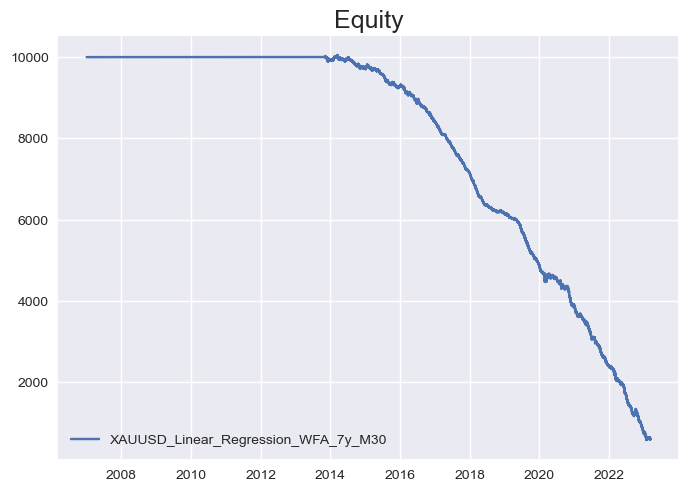

In [232]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [233]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [234]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [235]:
data = XAUUSD['M30']
window_size = 252 * 8 * 48
WFA = '8y'

In [236]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [237]:
test = ml.Run()

In [238]:
test

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:30:00
Duration                   5912 days 17:30:00
Exposure Time [%]                   50.435112
Equity Final [$]                  1143.780444
Equity Peak [$]                  10006.901505
Return [%]                         -88.562196
Buy & Hold Return [%]              193.338852
Return (Ann.) [%]                  -10.268456
Volatility (Ann.) [%]                 3.81836
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -88.880053
Avg. Drawdown [%]                   -29.67392
Max. Drawdown Duration     3039 days 13:00:00
Avg. Drawdown Duration     1013 days 14:20:00
# Trades                                36384
Win Rate [%]                        53.133245
Best Trade [%]                       3.166816
Worst Trade [%]                     -4.837473
Avg. Trade [%]                    

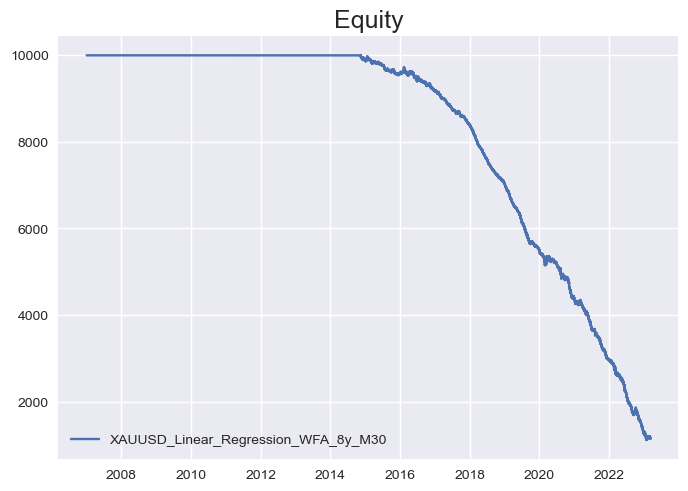

In [239]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [240]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [241]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')